In [108]:
from efficientunet import *
# from trashes.trash2.models import Resv2Unet
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.special import expit
import IPython.display as ipd
from scipy.signal import savgol_filter
from utils.normalize_process import process
from utils.normalize_process import get_zeros
from tqdm import tqdm
import os
%matplotlib inline

In [109]:
def mag_normalize(mag):
    return 10*mag/(np.mean(mag**2) + 1e-1)

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return np.log(np.maximum(x,clip_val) * C)

def stft_process(stft,mask=False):
    mag = np.abs(stft)
    phase = np.angle(stft)
    
    mag = mag_normalize(mag)
    mag = dynamic_range_compression(mag)
#     phase = unwrap(phase)
    mag = mag[np.newaxis,:,:]
    phase = phase[np.newaxis,:,:]
    
    if mask:
        m = make_mask(mag)
        conc = np.concatenate([mag,phase,m],axis=0)
    else:
        conc = np.concatenate([mag,phase],axis=0)
    return conc

def make_mask(mag):
    mask = np.zeros_like(mag)
    m = mag.mean()
    s = mag.std()
#     print(m,s)
    mask[mag>m + 1*s] = 1
    return mask

def round_thres(mask,threshold = 0.5):
    copy = mask.copy()
    copy[mask>threshold] = 1
    copy[mask<=threshold] = 0
    return copy

def weighted_cosine_distance(a,b):
    weight = np.abs(a-b)
    weight = weight/np.mean(weight)
    a_sum = np.sqrt(np.sum((weight*a)**2))
    b_sum = np.sqrt(np.sum((weight*b)**2))
    cos_ = np.sum(weight*a*b)/((a_sum*b_sum))
#     plt.plot(a)
#     plt.plot(b)
    return np.arccos(cos_)

def cosine_distance(a,b):
    a_sum = np.sqrt(np.sum(a**2))
    b_sum = np.sqrt(np.sum(b**2))
    cos_ = np.sum(a*b)/(a_sum*b_sum)
#     plt.plot(a)
#     plt.plot(b)
    return np.arccos(cos_)
#     return np.arccos(cos_)/np.pi ## angular distance

In [110]:
model = get_efficientunet_b4(out_channels=3, concat_input=True, pretrained=False)
model.load_state_dict(torch.load('./effb4-19-371.pth',map_location = lambda storage,loc:storage))
model.cuda()
model.eval()

EfficientUnet(
  (encoder): Encoder(
    (stem_conv): Conv2dSamePadding(
      2, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 1, 1), value=0.0)
    )
    (stem_batch_norm): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (stem_swish): Swish()
    (blocks): ModuleList(
      (0): MBConvBlock(
        (swish): Swish()
        (_depthwise_conv): Conv2dSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_paddin

In [118]:
trues = []
preds = []
xs_trues = []
xs_preds = []
cqs_trues = []
cqs_preds = []
pitch_trues = []
pitch_preds = []
signal_trues = []
signal_preds = []
for file in tqdm(os.listdir('../eggdata/TestSTFT/data/')[:100]):
    [S,E] = np.load('../eggdata/TestSTFT/data/'+file)
    S = librosa.util.normalize(S)
    inp = stft_process(S,mask=False)
    inp = torch.Tensor(inp).unsqueeze(0).cuda()
    with torch.no_grad():
        out = model(inp)
    out = out.cpu().detach().numpy()
    out = np.mean(out,axis=0)[np.newaxis,:,:,:]

    mag = out[0,0,:,:]
    phase = out[0,1,:,:]
    mask = out[0,2,:,:]

    mag = np.exp(mag)
    mask = round_thres(expit(mask),0.9)
    
    s = stft_process(E,mask=True)
    mag_original = s[0,:,:]
    phase_original = s[1,:,:]
    mask_original = s[2,:,:]
    mag_original = np.exp(mag_original)
    
    recon_signal = librosa.istft(mask*mag*(np.cos(phase_original)+1j*np.sin(phase_original)),hop_length=128,win_length=512)
    original_signal = librosa.istft(mask_original*mag_original*(np.cos(phase_original)+1j*np.sin(phase_original)),hop_length=128,win_length=512)
    
    signal_trues.append(original_signal)
    signal_preds.append(recon_signal)
    
    original_signal = process(original_signal)
    recon_signal = process(recon_signal)
    ori_zeros = get_zeros(original_signal+0.143)
    recon_zeros = get_zeros(recon_signal+0.143)
    
    if original_signal[ori_zeros[0]] >= original_signal[ori_zeros[0]+1]:
        ori_zeros = ori_zeros[1:]
    if recon_signal[recon_zeros[0]] >= recon_signal[recon_zeros[0]+1]:
        recon_zeros = recon_zeros[1:]
        
    cqs = []
    sqs = []
    pitches = []
    xs = []
    for i in range(len(ori_zeros)//2-2):
        pitch = 16000/(ori_zeros[2*i+2] - ori_zeros[2*i])
        cq = (ori_zeros[2*i+1] - ori_zeros[2*i]) / (ori_zeros[2*i+2] - ori_zeros[2*i])
#         hi = get_zeros(original_signal[ori_zeros[2*i]:ori_zeros[2*i+1]])
        if 0.25<cq<0.8:
            xs.append(ori_zeros[2*i])
            cqs.append(cq)
#             sqs.append(sq)
            pitches.append(pitch)
    trues.append(np.mean(cqs))
    cqs_trues.append(cqs)
    xs_trues.append(xs)
    pitch_trues.append(pitches)
    
    cqs = []
    sqs = []
    pitches = [] 
    xs = []
    for i in range(len(recon_zeros)//2-2):
        pitch = 16000/(recon_zeros[2*i+2] - recon_zeros[2*i])
        cq = (recon_zeros[2*i+1] - recon_zeros[2*i]) / (recon_zeros[2*i+2] - recon_zeros[2*i])
#         hi = get_zeros(original_signal[ori_zeros[2*i]:ori_zeros[2*i+1]])
        if 0.25<cq<0.8:
            xs.append(recon_zeros[2*i])
            cqs.append(cq)
#             sqs.append(sq)
            pitches.append(pitch)

    preds.append(np.mean(cqs))
    cqs_preds.append(cqs)
    xs_preds.append(xs)
    pitch_preds.append(pitches)
    
#     _1d_input = torch.Tensor(normalize(original_signal[1000:1192])).unsqueeze(0).cuda()
#     with torch.no_grad():
#         out_1d = model_1d(_1d_input)   
#     out_1d = out_1d.cpu().detach().numpy()

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


In [119]:
cds = []
cds_process = []
for x,y in zip(signal_preds,signal_trues):
    region = process(y)!=0
    cds.append(cosine_distance(x[region],y[region]))
    cds_process.append(cosine_distance(process(x[region]),process(y[region])))

In [120]:
print(np.mean(cds))
print(np.mean(cds_process))

0.43427804
0.28678447


In [121]:
cosine_distance(process(x)[6000:12000],process(y)[6000:12000])

0.18468633

In [122]:
weighted_cosine_distance(process(x)[6000:12000],process(y)[6000:12000])

1.3538947

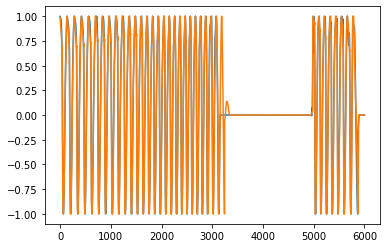

In [123]:
plt.plot(process(x)[6000:12000])
plt.plot(process(y)[6000:12000])

In [124]:
original_signal = process(signal_trues[0])
recon_signal = process(signal_preds[0])
ori_zeros = get_zeros(original_signal+0.143)
recon_zeros = get_zeros(recon_signal+0.143)

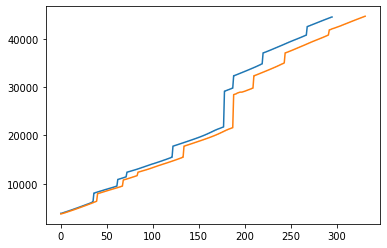

In [125]:
plt.plot(ori_zeros)
plt.plot(recon_zeros)

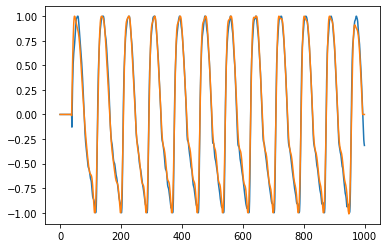

In [126]:
plt.plot(process(signal_trues[7])[:1000])
# plt.plot(ori_zeros,process(signal_trues[7])[:1000][ori_zeros],'o')
plt.plot(process(signal_preds[7][:1000]))
# plt.plot(recon_zeros,process(signal_preds[7])[:1000][recon_zeros],'o')

In [127]:
ori_zeros = get_zeros(process(signal_trues[7])[:1000]+0.143)
recon_zeros = get_zeros(process(signal_preds[7])[:1000]+0.143)

0.00014949912024653234


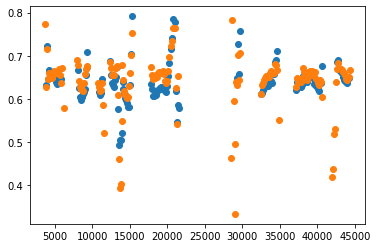

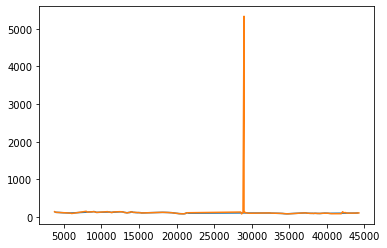

0.028463472780936194


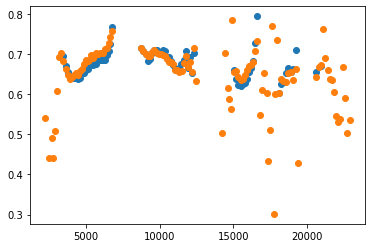

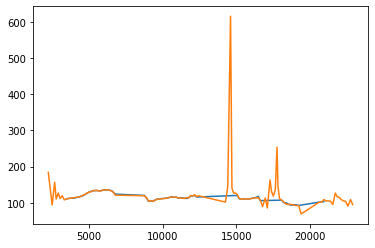

0.011766602765686751


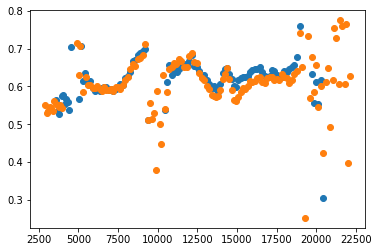

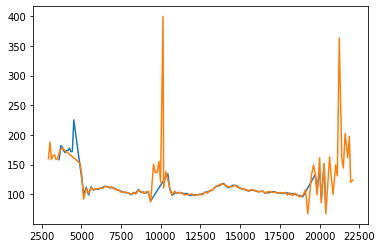

0.004019417890206989


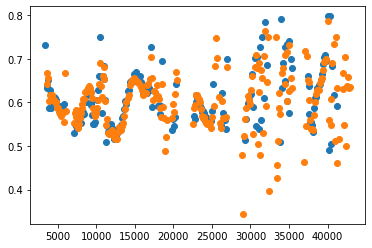

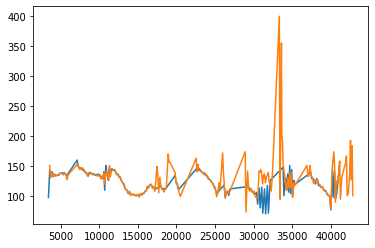

0.04366904487210721


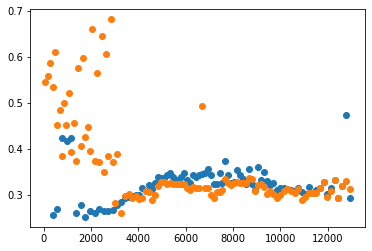

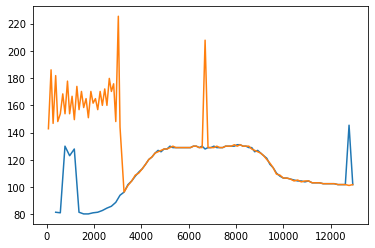

4


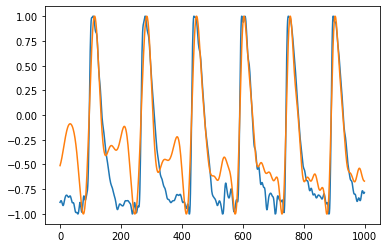

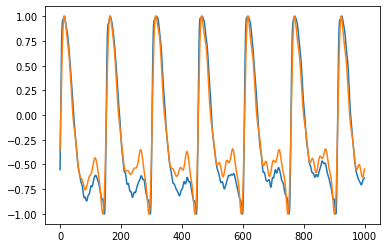

0.02481634895955992


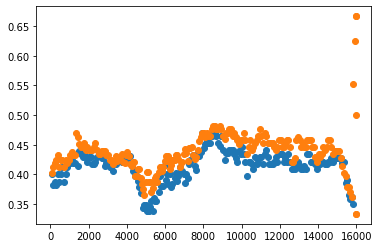

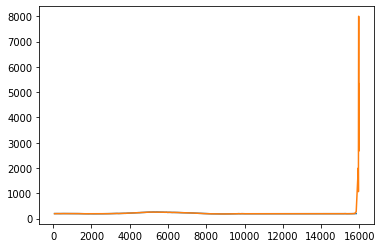

0.016671630427725237


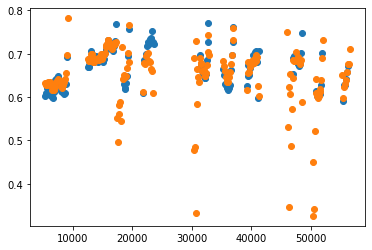

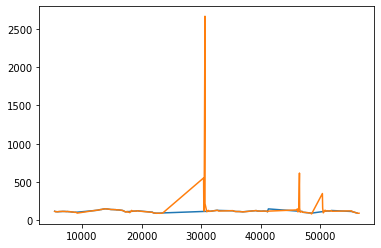

0.02113326476787869


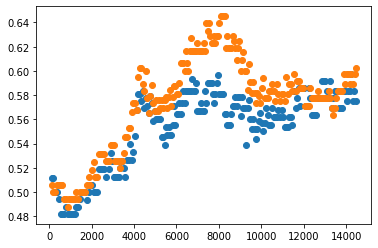

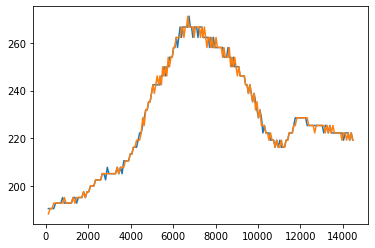

0.015580458385300755


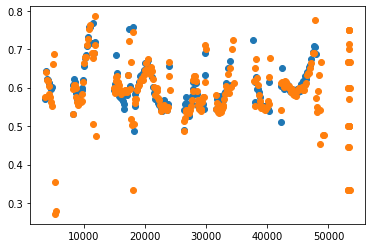

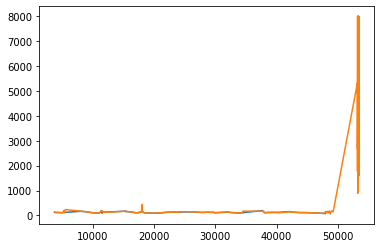

0.005742432294478683


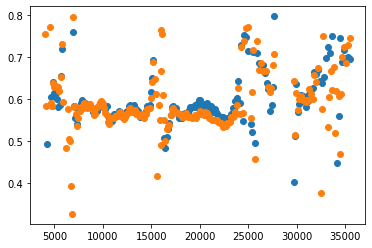

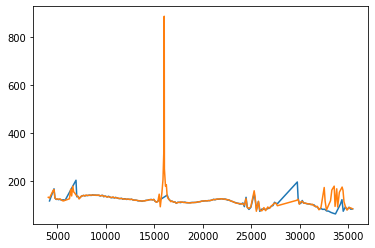

0.015986439871101377


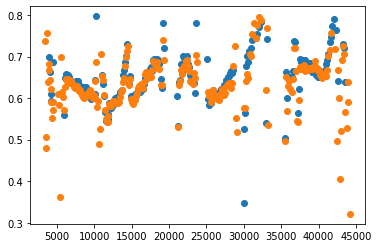

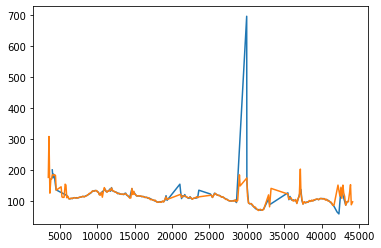

0.00199674486766499


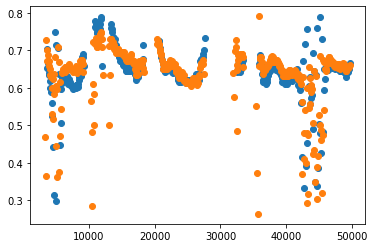

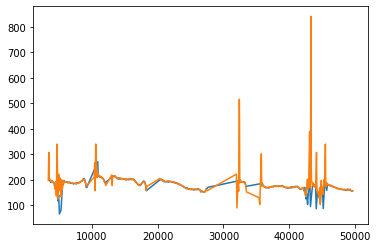

0.0018441051162146893


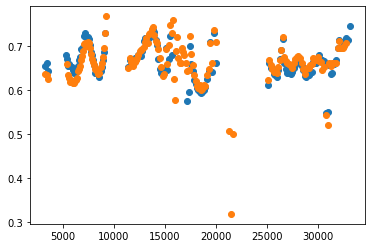

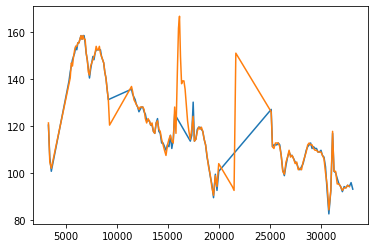

0.012265398300815966


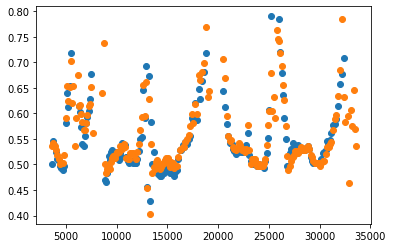

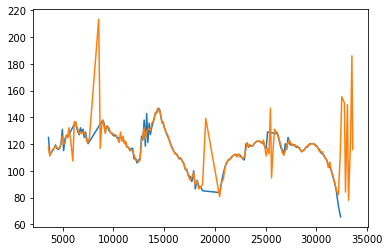

0.004374708913800984


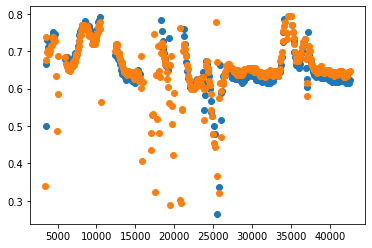

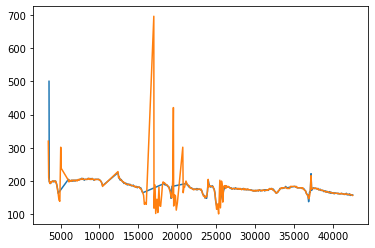

0.015109106016948481


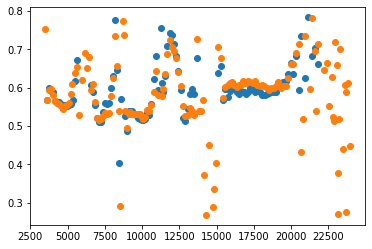

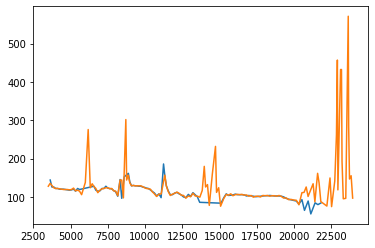

0.00706141623398282


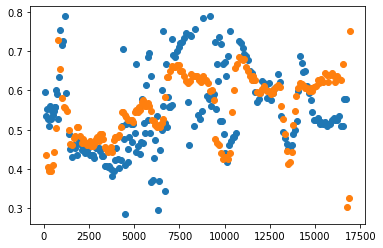

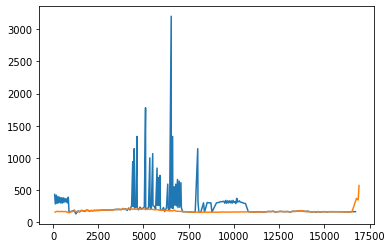

0.007281707064926701


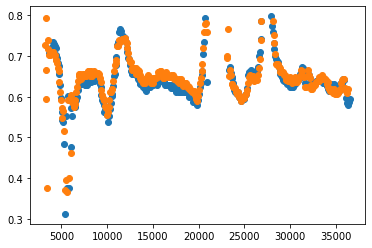

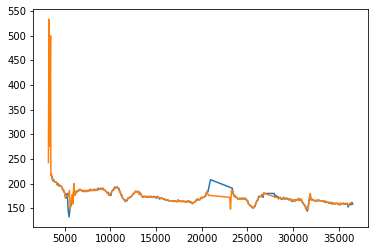

0.0408518211266069


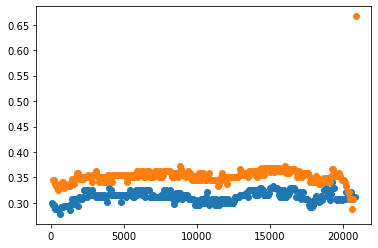

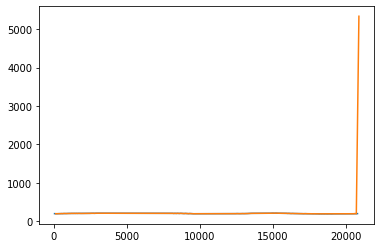

18


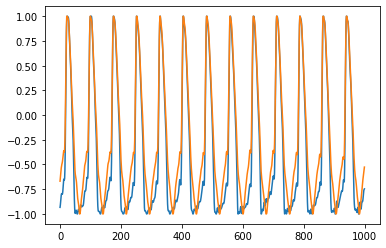

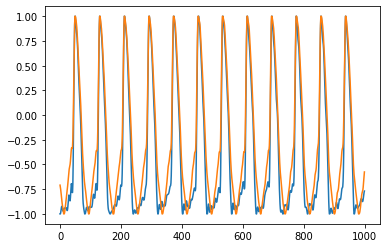

0.009567381389732899


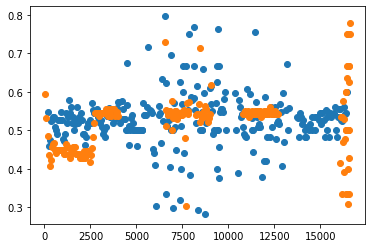

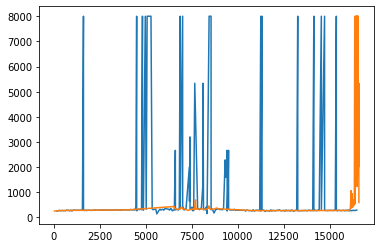

0.010846032032326591


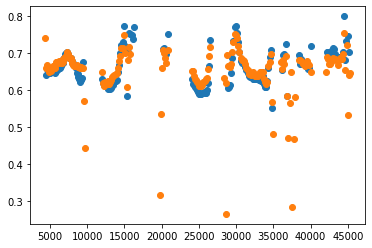

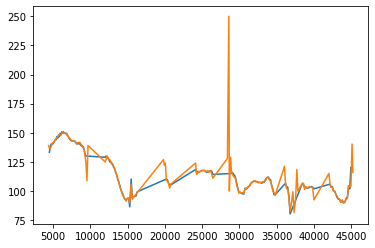

0.011158833899410081


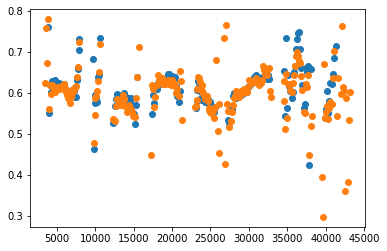

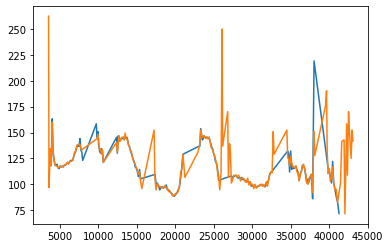

0.006628767684502601


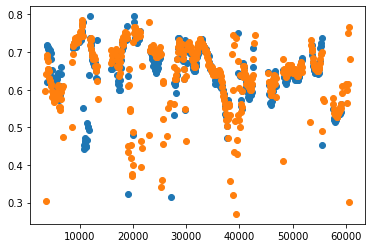

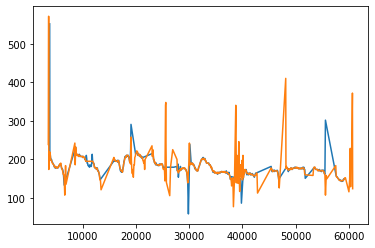

0.013257113448154723


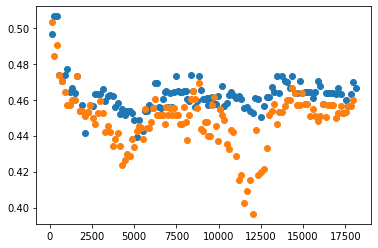

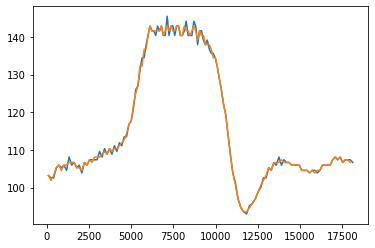

0.014868907084965355


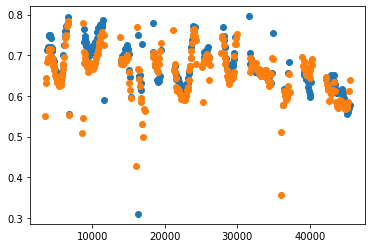

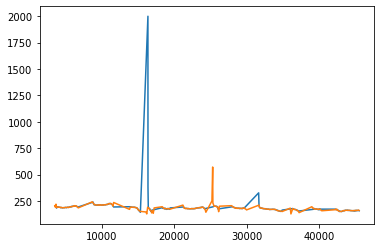

0.0028829382981215845


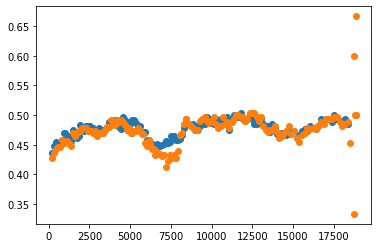

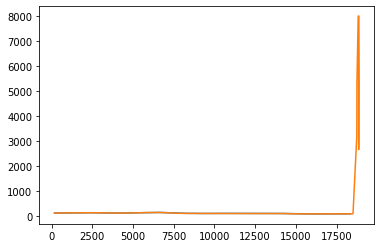

0.009540136903201046


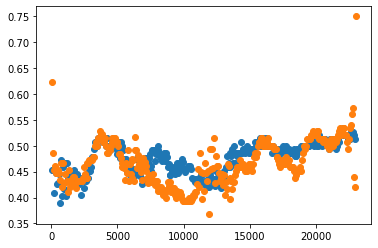

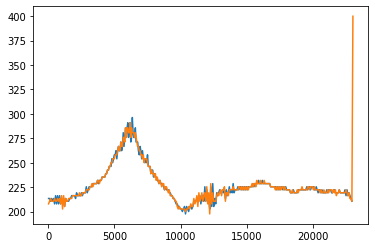

0.010470453373562782


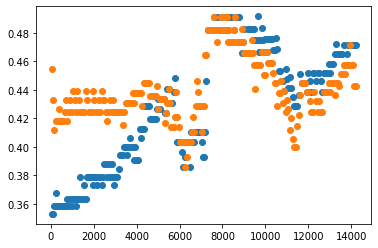

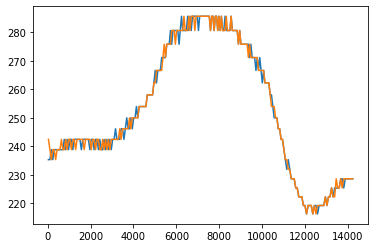

0.03452044134531035


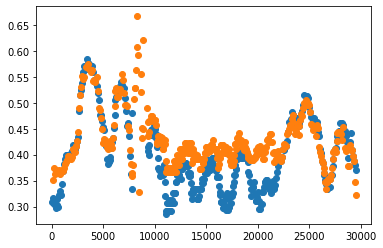

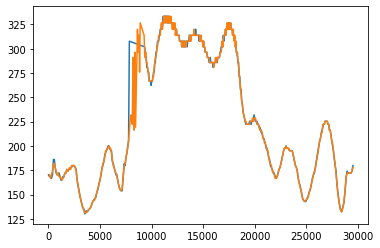

28


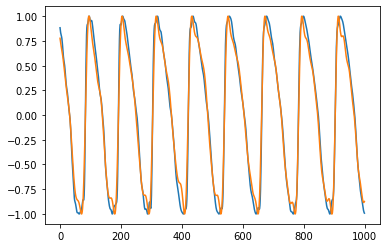

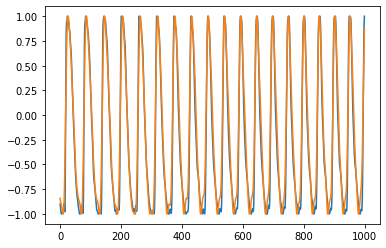

0.043746372050801674


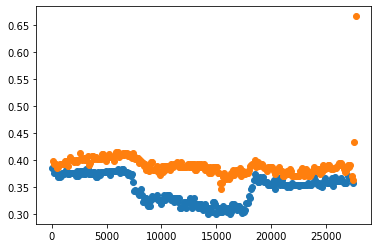

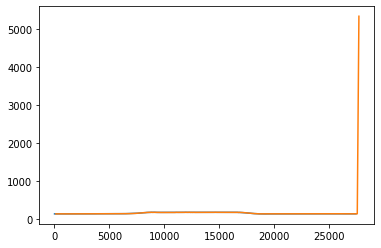

29


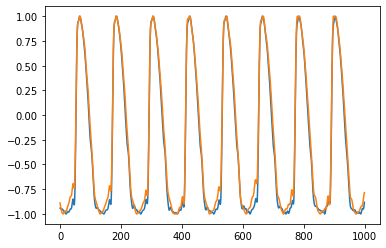

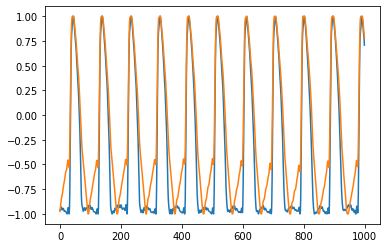

0.016508548737275253


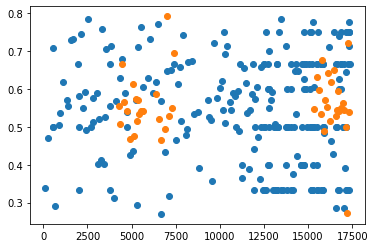

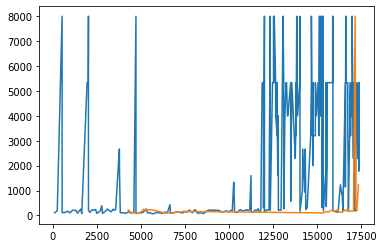

0.005995089910751483


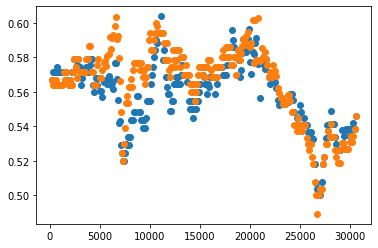

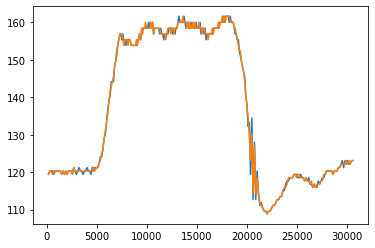

0.015427555406387516


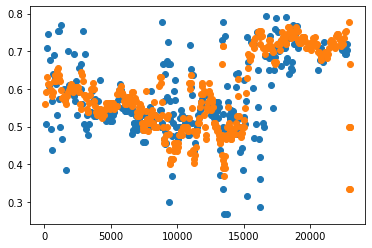

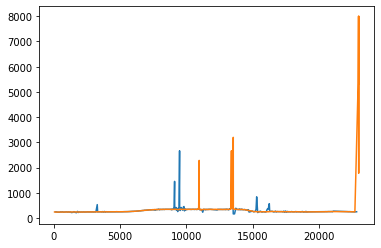

0.024914557872834253


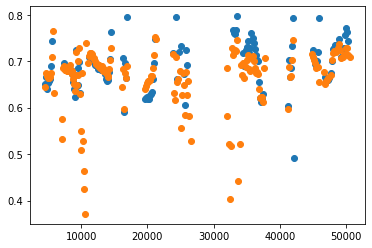

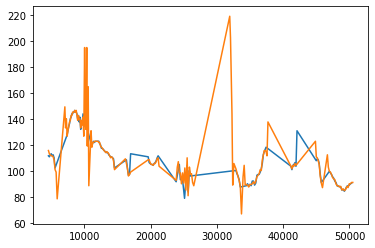

0.000367090351631405


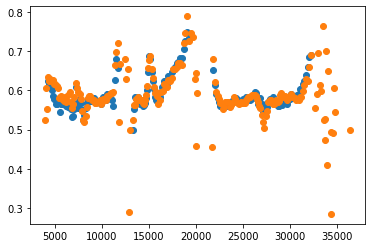

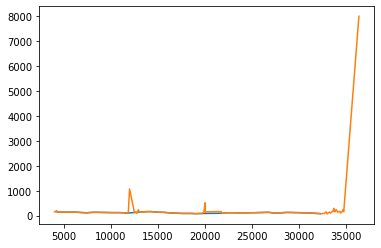

0.04540805735084874


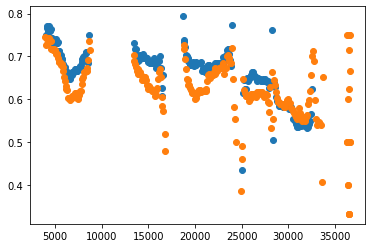

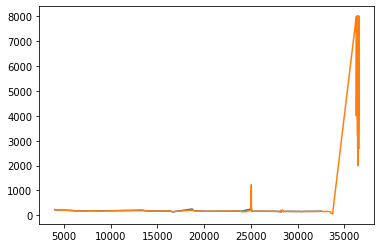

35


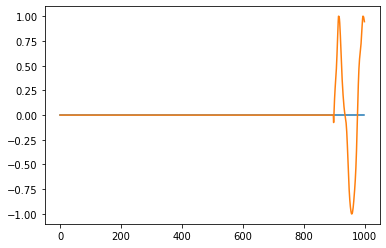

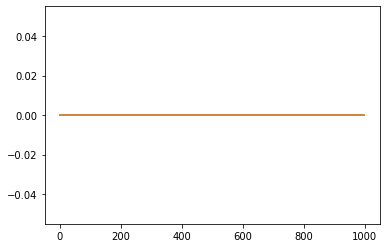

0.021005362324601484


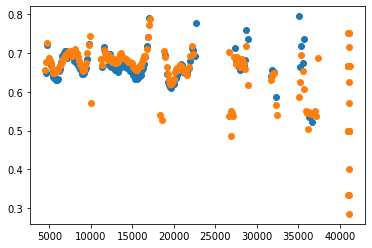

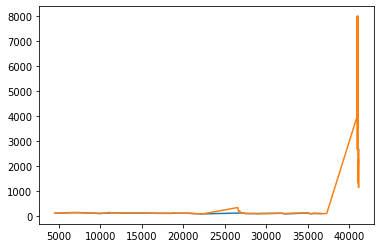

0.018321828350514546


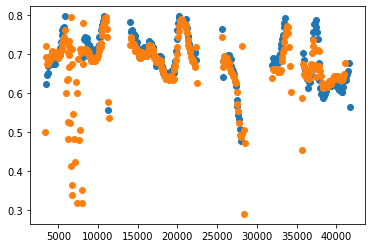

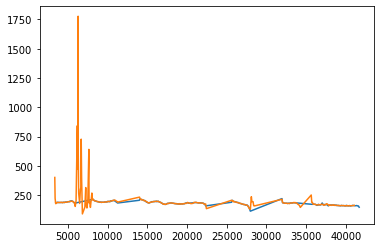

0.0019204499918967777


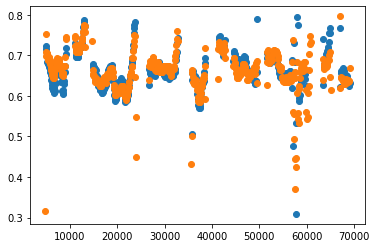

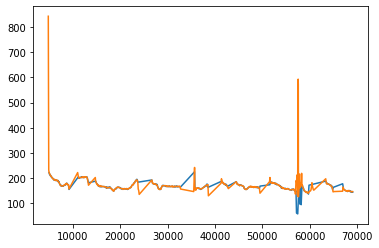

0.005349820949764217


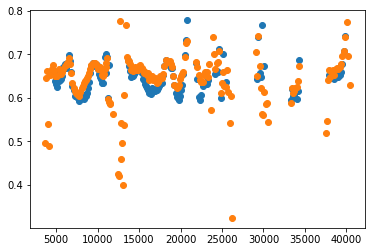

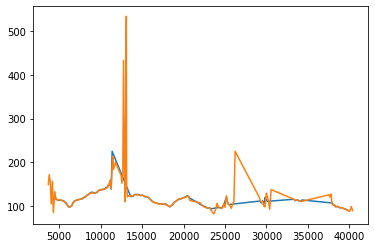

0.010472187675827416


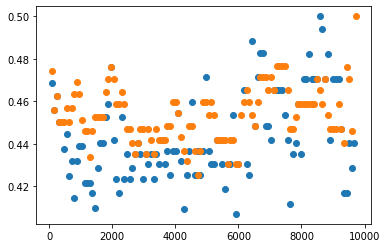

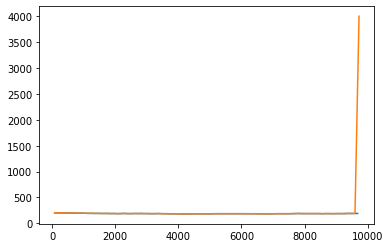

0.013501212669035367


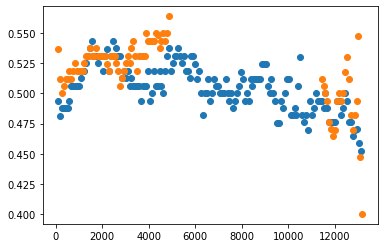

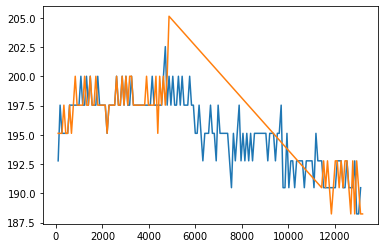

0.005916910020430044


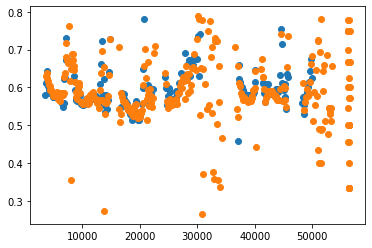

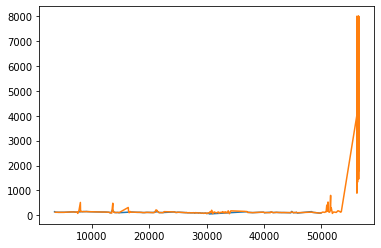

0.002485878441102818


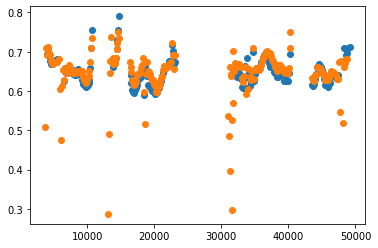

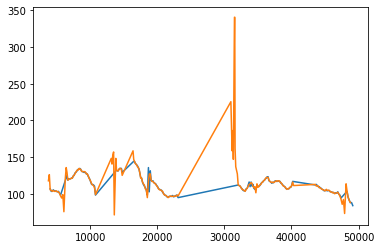

0.01042720305638778


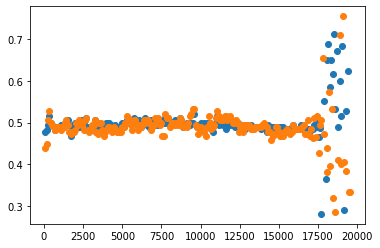

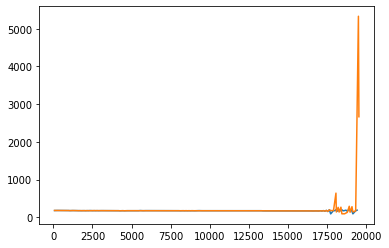

0.014328908804880913


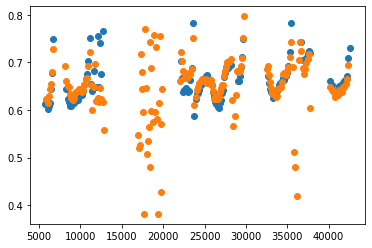

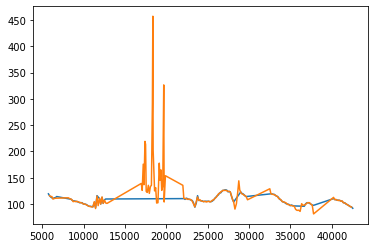

0.0028338958791250812


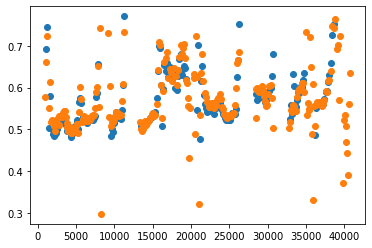

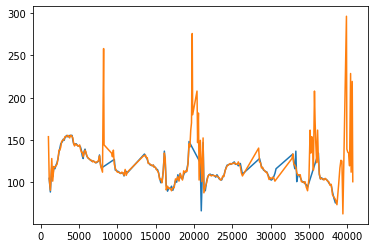

0.006461779825777003


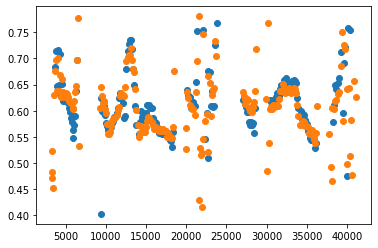

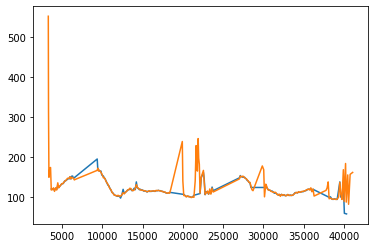

0.00034000836395120526


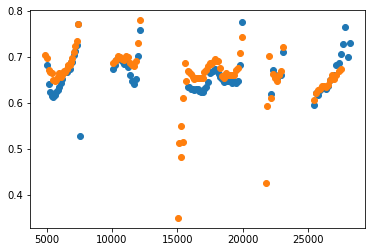

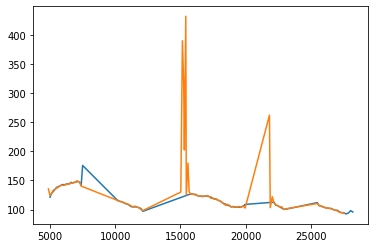

0.008758423504673929


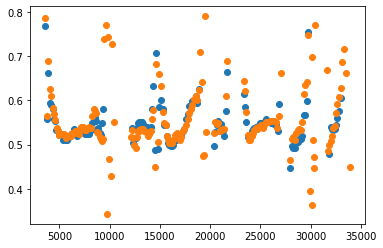

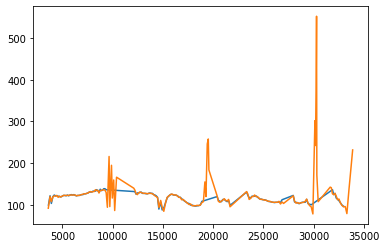

0.0017288638599695094


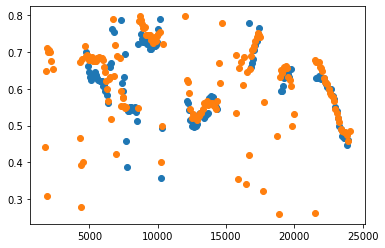

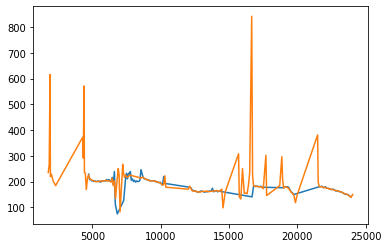

0.00830467924005407


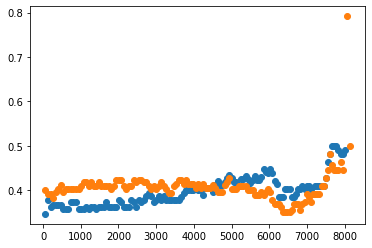

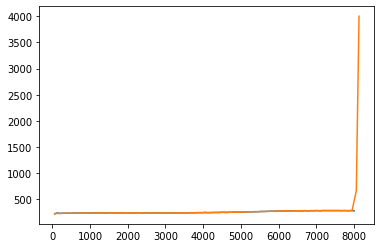

0.005830898386506911


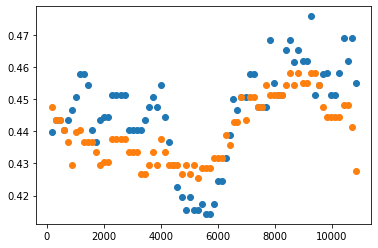

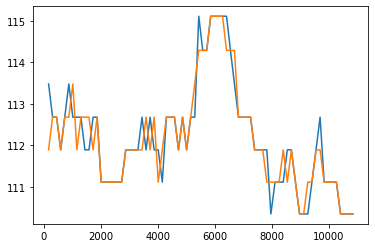

0.06584692919608004


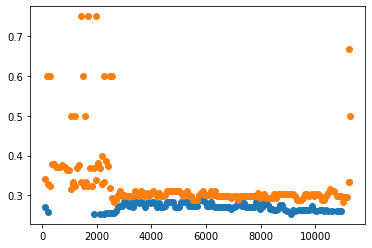

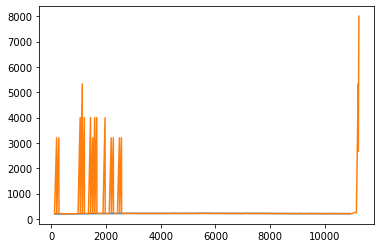

53


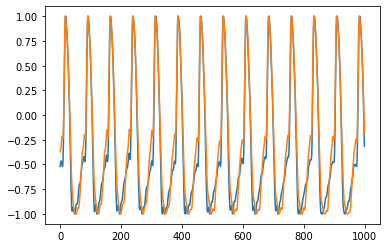

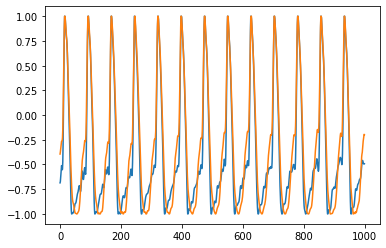

0.008025708111351615


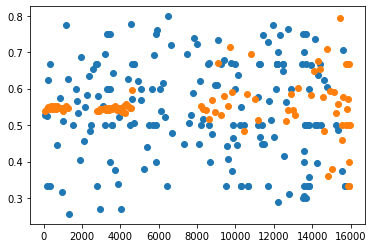

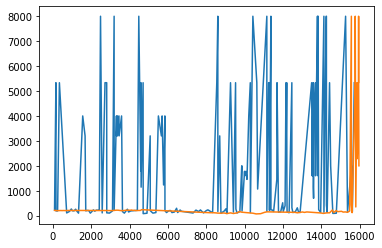

0.010299342821674995


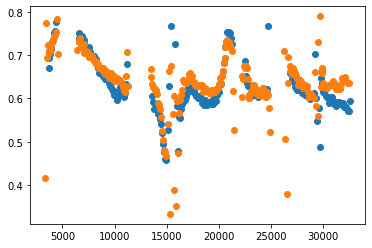

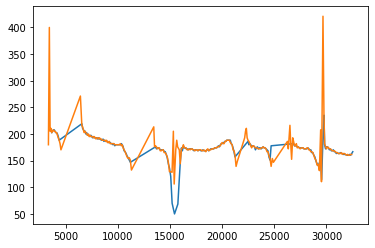

0.0002968344412058732


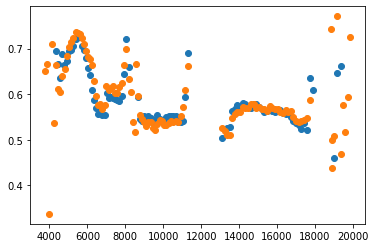

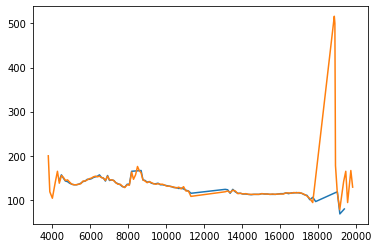

0.05896601728765638


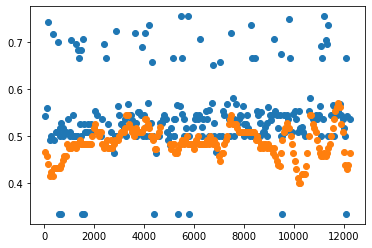

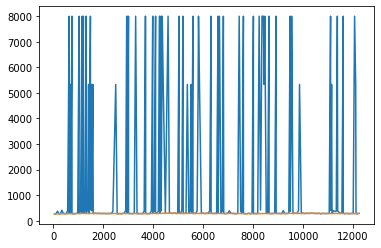

57


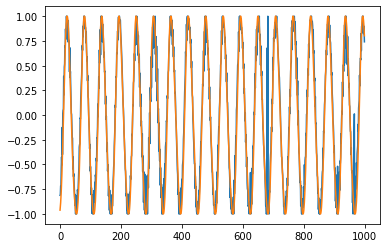

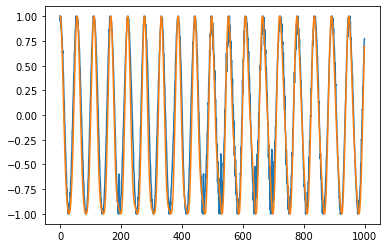

0.026637412649115122


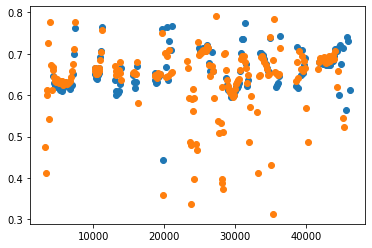

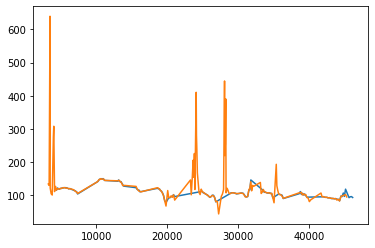

0.002491871119252642


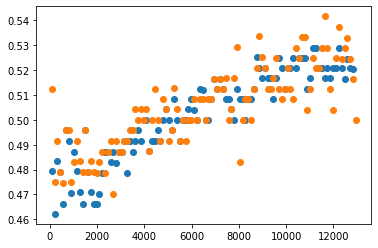

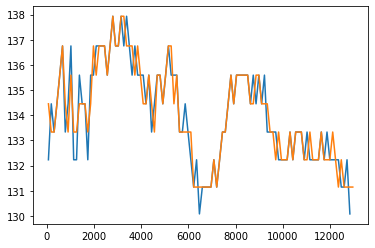

0.02246162602793561


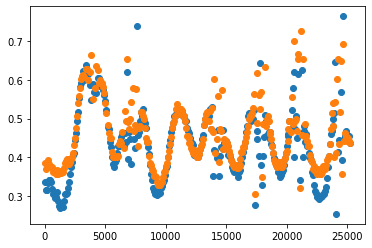

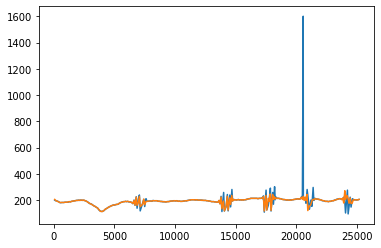

0.0017502339083587115


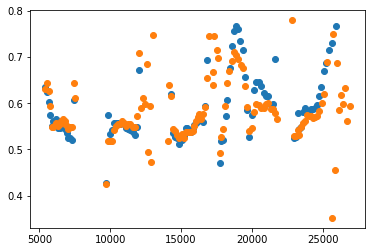

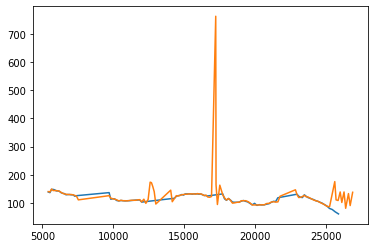

0.015450895689470334


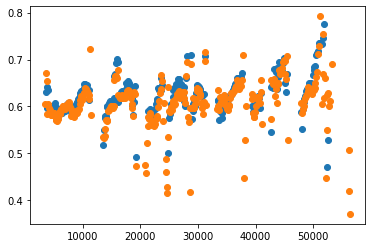

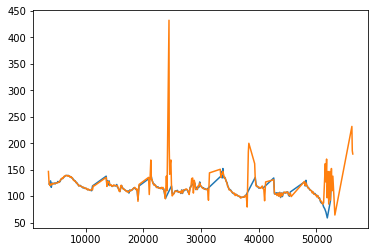

0.05402577214570503


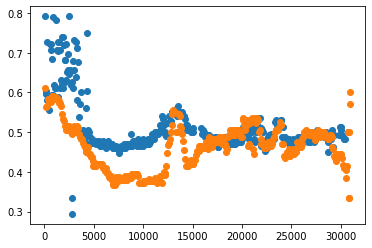

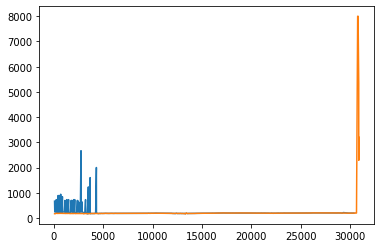

63


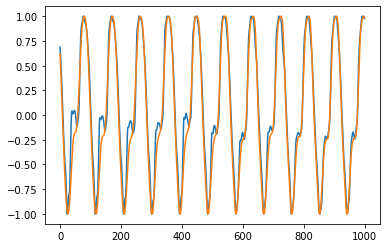

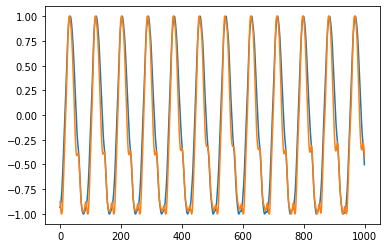

0.008335317538243348


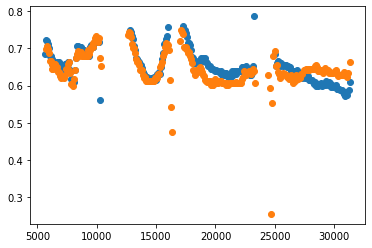

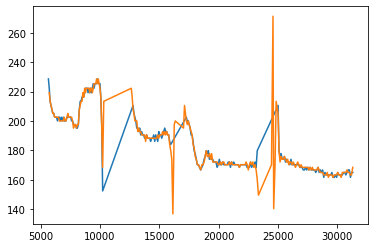

0.021213631227309626


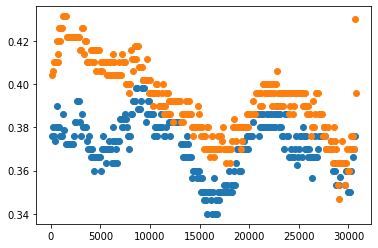

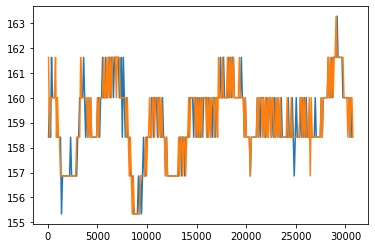

0.0006386125312152213


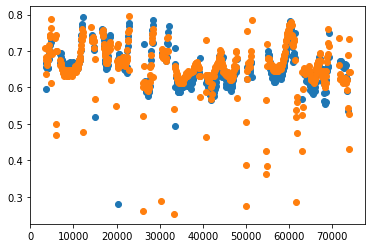

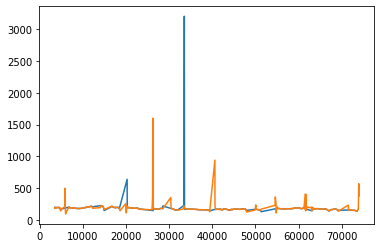

0.011541979211054154


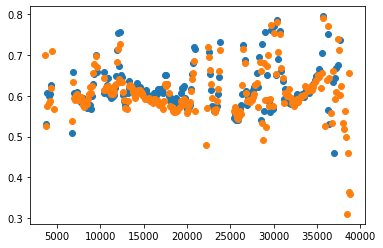

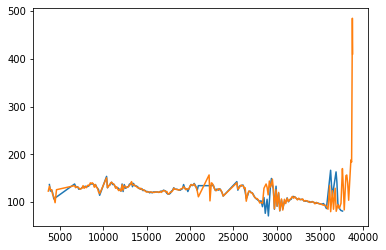

0.0067777464944580035


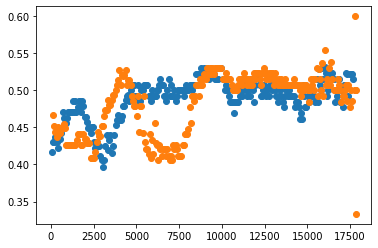

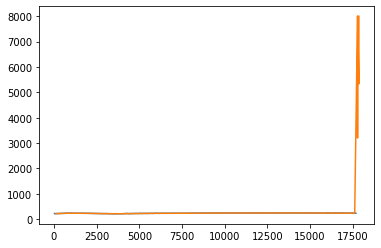

0.019912178349734355


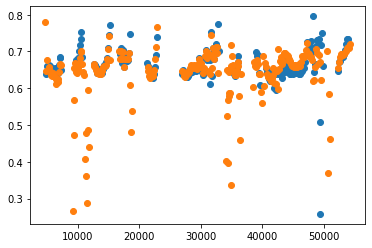

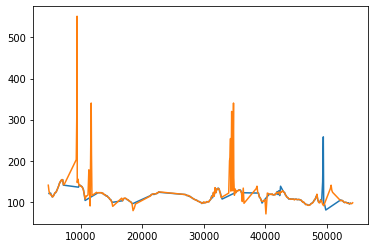

0.007133519968809399


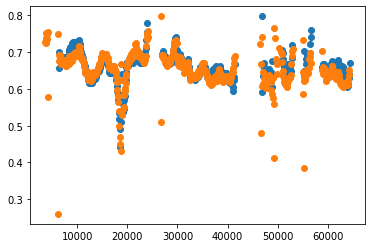

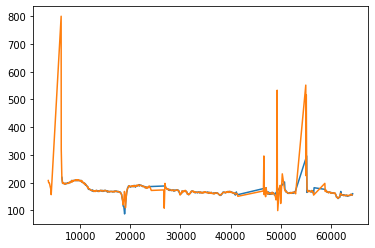

0.015408957639052367


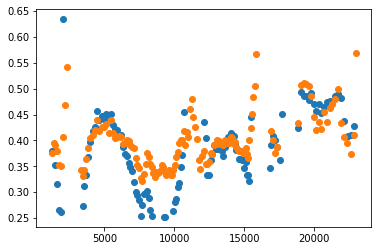

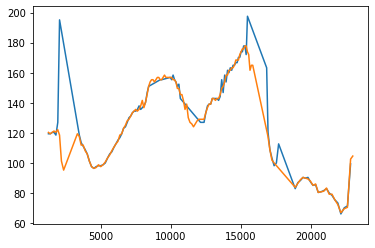

0.012137926571046398


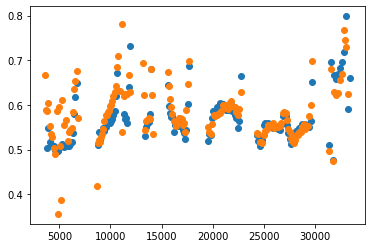

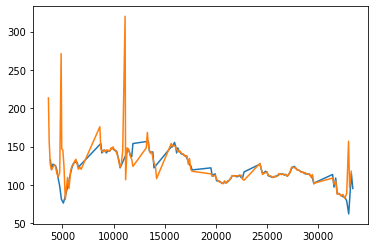

0.018169841265213038


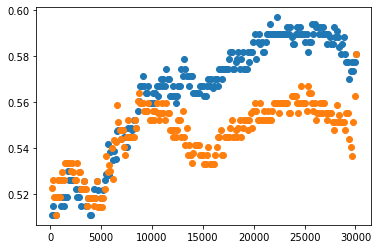

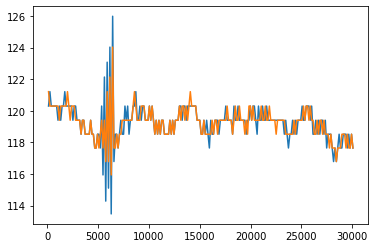

0.0022170549580697863


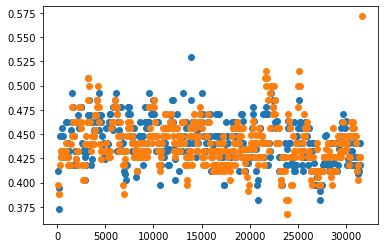

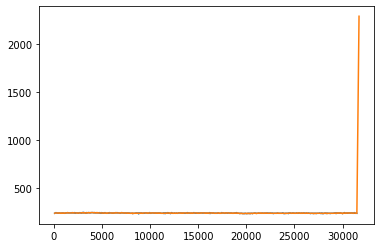

0.01772753896437307


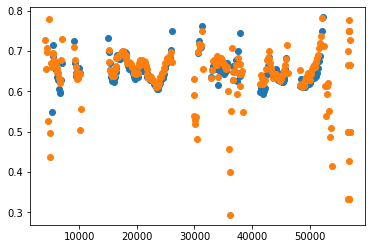

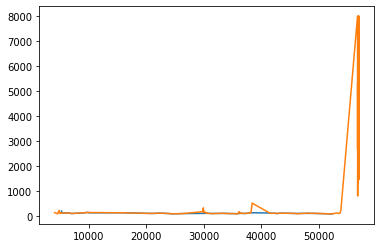

0.023451260927990214


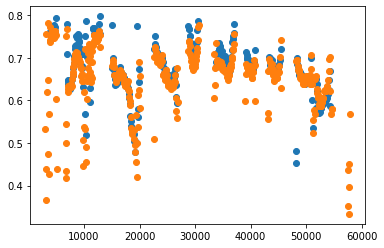

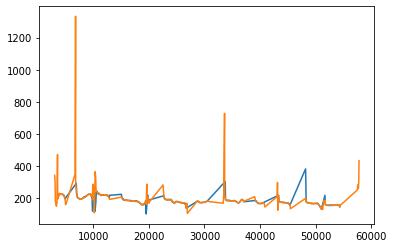

0.00599393946442528


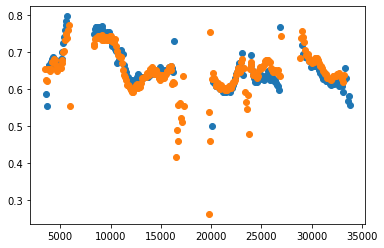

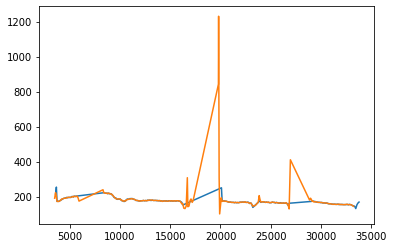

0.0027927575570569907


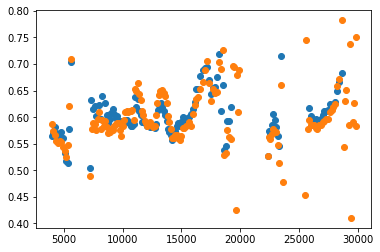

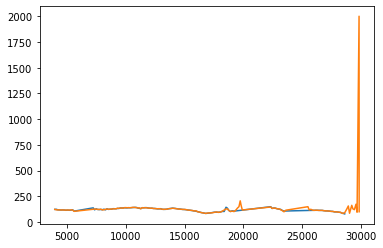

0.021781023242544162


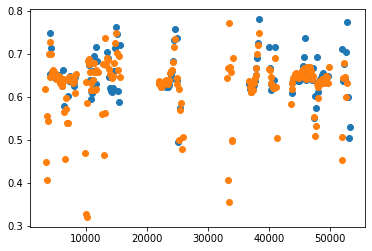

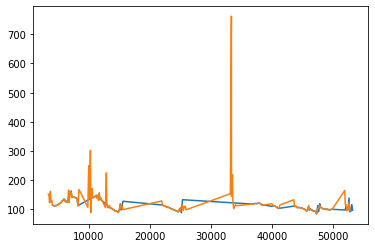

0.028644978402139865


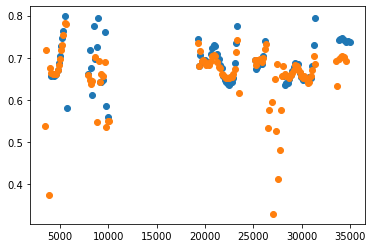

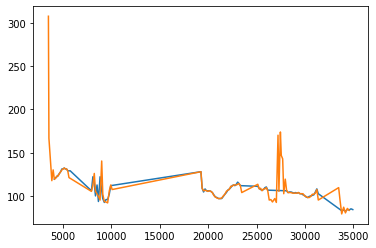

0.0327709986764847


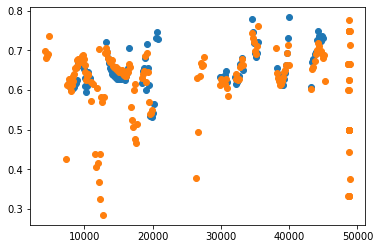

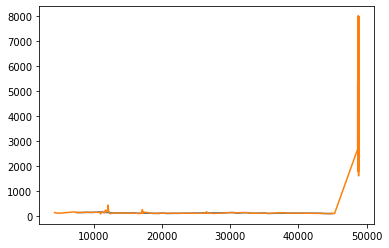

81


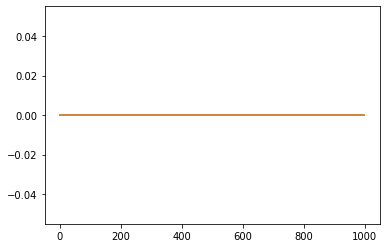

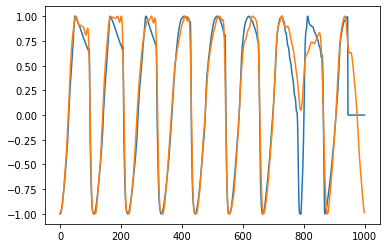

0.04059118459424127


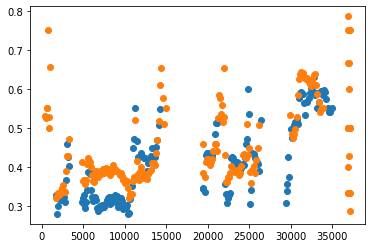

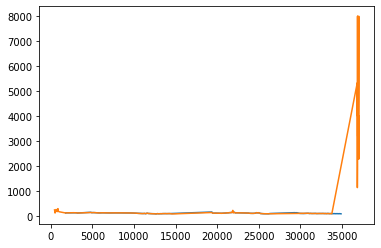

82


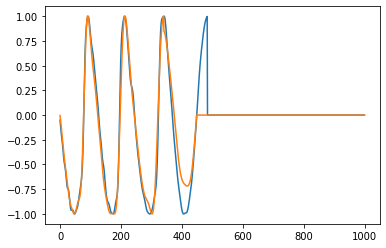

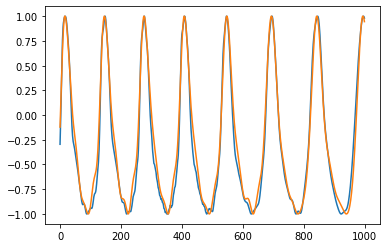

0.006124737896684551


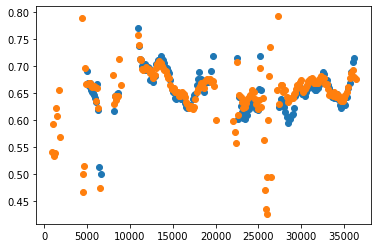

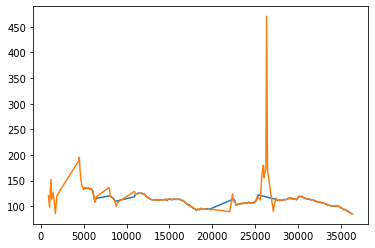

0.00033543316718731564


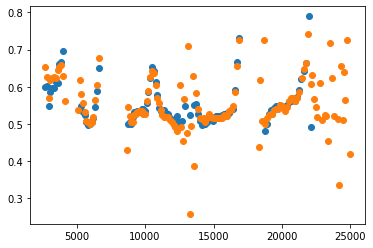

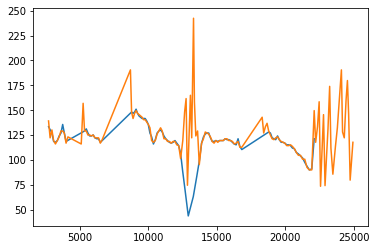

0.012336694613934607


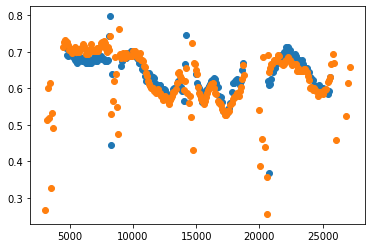

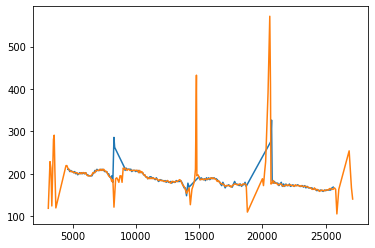

0.06646825024730058


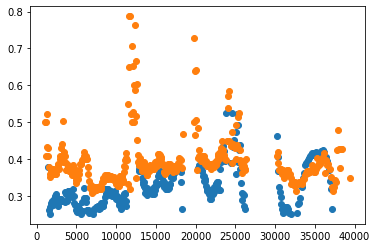

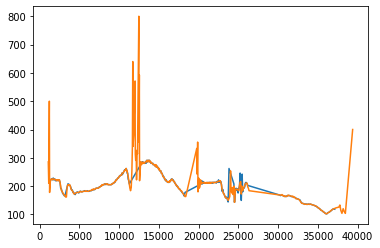

86


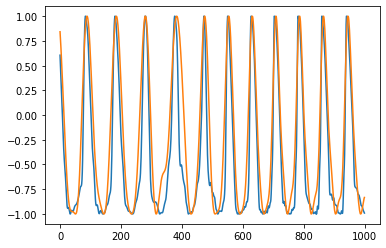

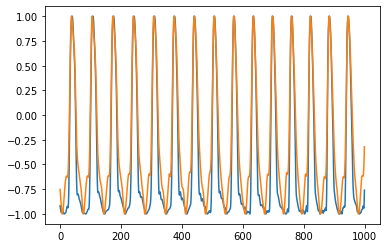

0.0024984171077216955


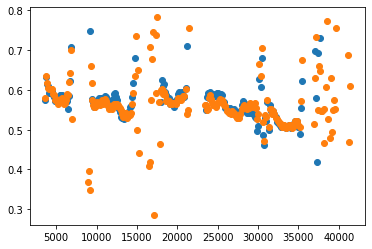

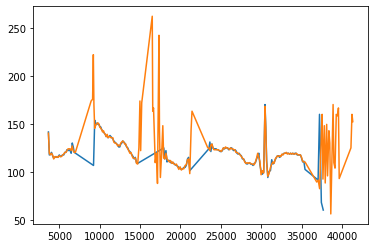

0.0025228346503177734


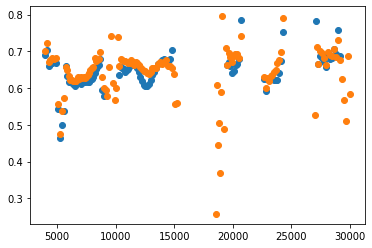

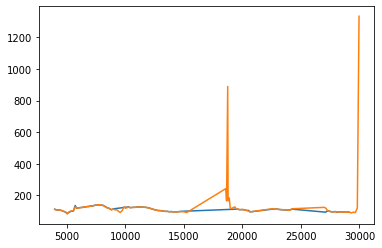

0.04401551794854297


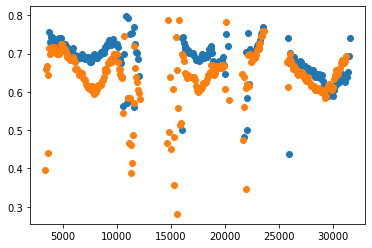

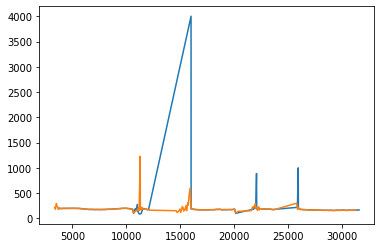

89


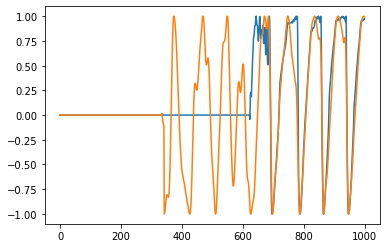

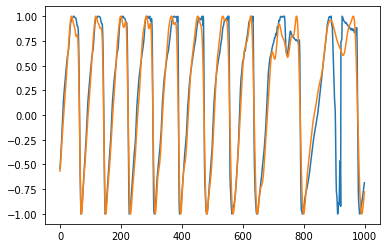

0.0052273145170655955


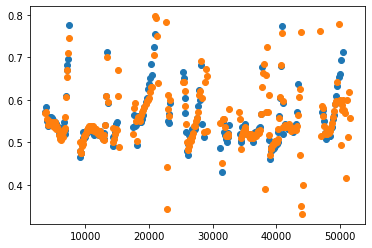

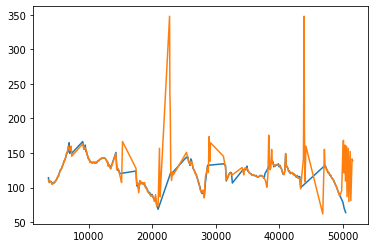

0.004558838653810793


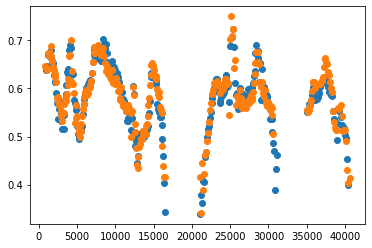

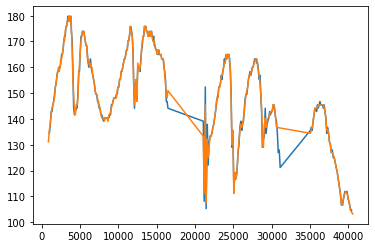

0.011040295165126501


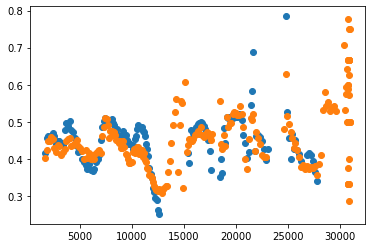

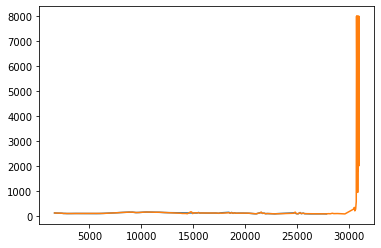

0.011918323032088618


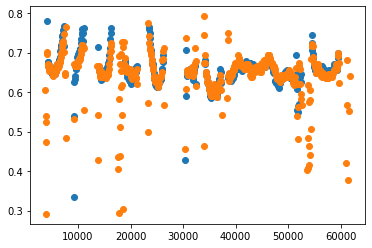

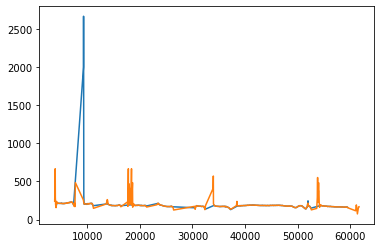

0.027277570137764495


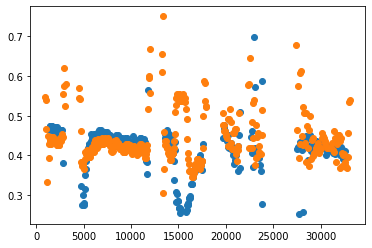

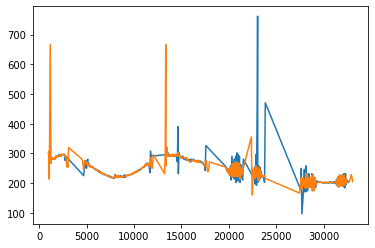

0.050307970635054655


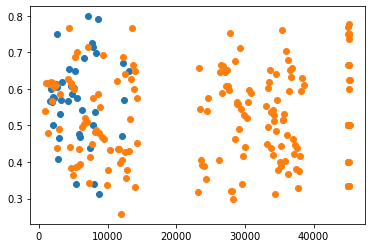

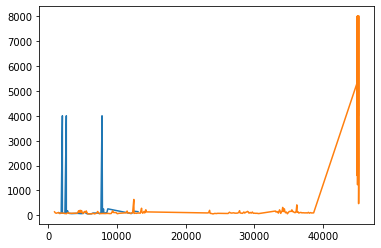

95


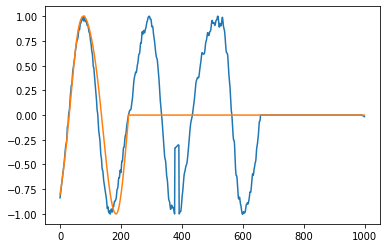

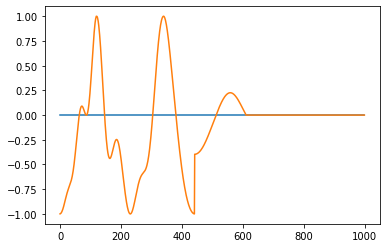

0.02926325774374028


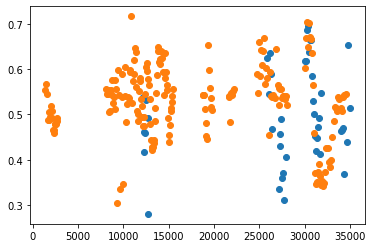

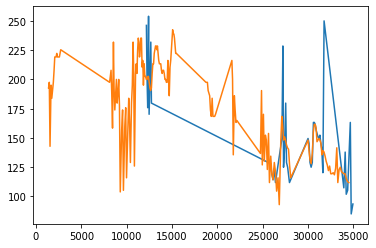

0.009141701555880566


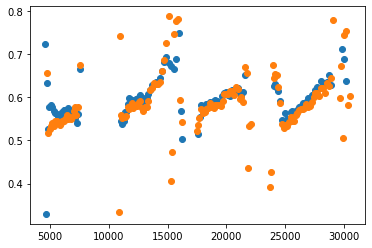

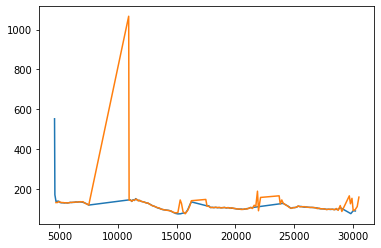

98


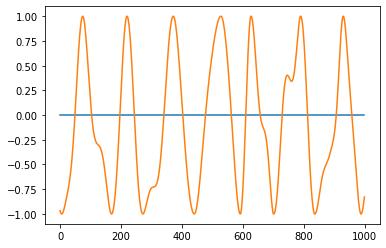

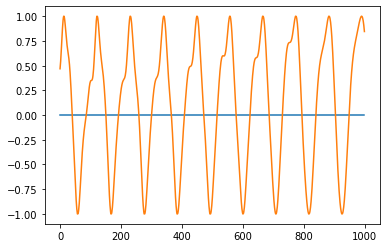

0.008562947590724623


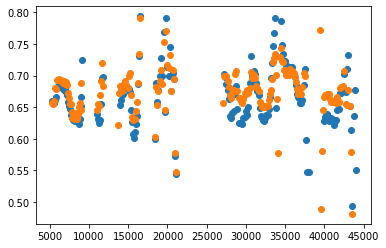

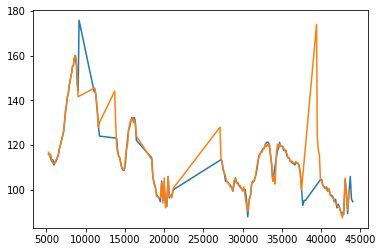

In [129]:
diffs = []
for idx,(x,y) in enumerate(zip(trues,preds)):
    diff = np.abs(x-y)
    diffs.append(diff)
    if diff <0.1:
        print(diff)
        plt.plot(xs_trues[idx],cqs_trues[idx],'o')
        plt.plot(xs_preds[idx],cqs_preds[idx],'o')
        plt.show()
        plt.plot(xs_trues[idx],pitch_trues[idx])
        plt.plot(xs_preds[idx],pitch_preds[idx])
        plt.show()
    if diff > 0.03:
        print(idx)
        plt.plot(process(signal_trues[idx])[3000:4000])
        plt.plot(process(signal_preds[idx])[3000:4000])
        plt.show()
        plt.plot(process(signal_trues[idx])[10000:11000])
        plt.plot(process(signal_preds[idx])[10000:11000])
        plt.show()

In [130]:
np.mean(diffs)

0.016593589407855963